<a href="https://colab.research.google.com/github/jatoogunhyo/dart_disclosure/blob/main/basic_listing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 질문: 근래 코스피 상장사들의 자기주식 취득 현황은 어떻게 될까?

  (배경-금감원 서식)
*   자기주식 취득은 법에 따라 금감원 공시(주요사항보고서)로 제출
  - 이사회에서 '결의'한 시점에 제출된 공시이므로, 취득'예정'수량/금액임
  - 실제 취득은 결의한 수량/금액보다 적을 수 있음
  <br/>
* 자기주식 취득이 완료되면 자기주식 취득결과 보고서를 금감원 공시로 제출
  - 그러나 주요사항보고서는 OpenDart에서 서비스하는 반면, 결과보고서는 OpenDart에서 서비스하지 않음

(배경-거래소 신고)
*   자기주식 취득을 위해 장내에서 주문 제출시 상장법인은 거래소에 사전에 신고하고, 주문호가에 자사주 매매에 관한 내용이 태깅됨
  - 이는 자본시장법 위반을 방지하기 위한 모니터링임
  - 관할부서는 공시부가 아닌 주식시장부/코스닥시장부
  - 대상 시스템은 상공시스템이 아닌 Exture
* 그러나 거래소는 시장을 운영하는 곳으로, 장외 취득/처분 수량은 거래소 시스템에 신고되지 않음
  - 장외 수량은 금감원 서식(결정공시 및 결과보고서)으로만 확인 가능
  <br/>

___
### ※ 데이터 수집 및 시각화 방향
#### 1. OpenDART를 통해 자기주식 관련 금감원 공시 내용 수집
* 전체 자사주 매매 결의 수량 추이를 확인
#### 2. 금감원 공시 내용을 토대로 장내/장외 취득처분 수량 구분
* 만약 장외수량이 미미하다면 거래소 데이터 활용 가능
#### 3. 장내 자사주 매매 관련 데이터를 거래소에서 취득
* *****'장내'*****  자사주 매매 결의 수량 추이를 확인




# 파이썬 세팅

* 필요한 패키지 Import

In [1]:
import pandas as pd
import requests
from io import BytesIO, StringIO
from time import sleep
from tqdm import tqdm
from bs4 import BeautifulSoup
import json
import re
import numpy as np

* 시각화를 위한 세팅(코랩)
코랩 환경에서 시각화에 한글이 깨지지 않도록 조치

In [2]:
# 필요한 라이브러리 설치
!pip install adjustText

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

# 연도별 기본자료(상장회사수, 시가총액, 거래대금 등) 구하기
전반적인 상장사 숫자와 시가총액 등 배경을 확인

### 1) 정보데이터시스템(data.krx.co.kr)에서 자동으로 자료 다운받기

In [3]:
#거래소 홈페이지에서 불러오기
#화면번호 42002(주요통계추이)
start_year = '2000'
end_year = '2023'
gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp_data = {
    'locale': 'ko_KR',
    'mktId': 'ALL', # 시장구분
    'pdTpCd': 'Y',
    #'strtDd': '20241122',
    #'endDd': '20241224',
    'strtYy': start_year,
    #'strtMm': '11',
    'endYy': end_year,
    #'endMm': '12',
    'share': '2', # 주식 단위
    'money': '5', # 금액 단위
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/EASY/main/MDCEASY00303'
}

headers = {
    'Referer': 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC03010201',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

otp = requests.post(gen_otp_url, gen_otp_data, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)


df_listed = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')

In [4]:
#불러온 데이터 확인
df_listed

,연도,회사수,종목수,상장주식수,상장자본금,상장주식시가총액,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균,회전율_상장주식,회전율_시가총액
0,2023,2670,2787,115803780.0,148701175397388,2562011711548156,405979428.0,1657059.0,4809278837889412,19629709542406,354.94,200.46
1,2022,2569,2690,113226353.0,144509621083400,2086643751594151,400890912.0,1629638.0,3914167850272827,15911251423873,362.12,165.79
2,2021,2487,2610,109420568.0,141465222227900,2654829828488724,693356302.0,2795792.0,6768651530131681,27292949718273,664.72,258.34
3,2020,2411,2531,100850720.0,135964968535761,2371736356308052,626832252.0,2527549.0,5709175198444849,23020867735665,642.33,316.70
4,2019,2355,2475,95583171.0,132083797924571,1722585791038533,318740356.0,1295693.0,2288218174314459,9301699895587,346.71,139.21
5,2018,2264,2380,89331611.0,127970827630241,1578460544082467,290624079.0,1191082.0,2800893376366844,11479071214618,349.04,152.46
6,2017,2195,2311,76926480.0,122990333141441,1893469018541703,261485458.0,1076072.0,2190902441153344,9016059428615,355.81,126.12
7,2016,2129,2249,70514379.0,120768528106171,1514271512890129,263537674.0,1071291.0,1948188345428724,7919464818816,395.76,132.41
8,2015,2030,2149,63671443.0,116444935005971,1448410480739801,262845886.0,1059862.0,2201463952211245,8876870775045,432.32,151.65
9,2014,1905,2035,59225137.0,117004667738471,1336765867949191,155004065.0,632670.0,1458804088606287,5954302402475,270.30,110.37


### 2) 다운받은 데이터프레임을 시각화(정적인 그림)

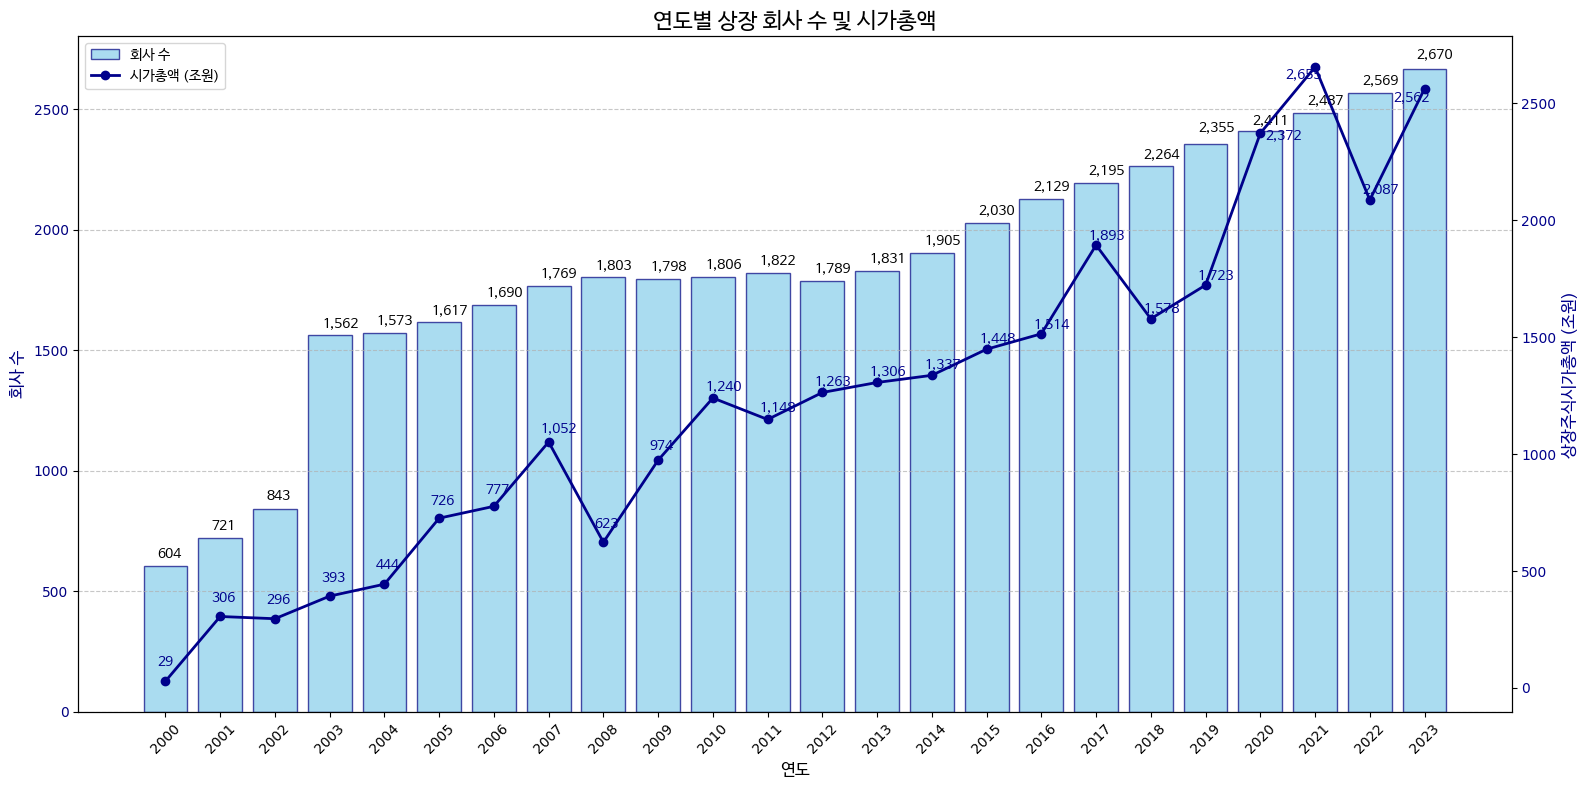

In [5]:
# 시가총액을 조 단위로 변환
df_listed['시가총액_조'] = df_listed['상장주식시가총액'] / 1_000_000_000_000

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(16, 8))

# 회사수 막대 그래프 (주축)
bars = ax1.bar(df_listed['연도'], df_listed['회사수'], color='skyblue', edgecolor='navy', alpha=0.7)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('회사 수', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 - 모든 연도 표시
plt.xticks(df_listed['연도'], rotation=45)

# 상장주식시가총액 선 그래프 (보조축)
ax2 = ax1.twinx()
line = ax2.plot(df_listed['연도'], df_listed['시가총액_조'], color='darkblue', linewidth=2, marker='o')
ax2.set_ylabel('상장주식시가총액 (조원)', fontproperties=font, fontsize=12, color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# 그래프 제목 설정
plt.title('연도별 상장 회사 수 및 시가총액', fontproperties=font, fontsize=16)

# 범례 추가 (왼쪽 상단에 함께 표시)
plt.legend([bars, line[0]], ['회사 수', '시가총액 (조원)'], loc='upper left', prop=font)

# 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 텍스트 레이블을 저장할 리스트
texts = []

# 데이터 레이블 추가 (회사 수)
for bar in bars:
    height = bar.get_height()
    texts.append(ax1.text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:,.0f}', ha='center', va='bottom', fontproperties=font))

# 데이터 레이블 추가 (시가총액)
for i, v in enumerate(df_listed['시가총액_조']):
    texts.append(ax2.text(df_listed['연도'][i], v, f'{v:,.0f}', ha='center', va='top', fontproperties=font, color='darkblue'))

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

### 3) 다운받은 데이터프레임을 시각화(인터액티브한 그림)

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 그래프 생성
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 회사수 막대 그래프
fig.add_trace(
    go.Bar(x=df_listed['연도'], y=df_listed['회사수'], name="회사 수",
           text=df_listed['회사수'], textposition='outside'),
    secondary_y=False,
)

# 시가총액 선 그래프
fig.add_trace(
    go.Scatter(x=df_listed['연도'], y=df_listed['시가총액_조'], name="시가총액 (조원)",
               mode='lines+markers+text', text=df_listed['시가총액_조'].round(0),
               textposition='top center'),
    secondary_y=True,
)

# 레이아웃 설정
fig.update_layout(
    title_text="연도별 상장 회사 수 및 시가총액",
    xaxis_title="연도",
    xaxis=dict(
        tickmode='array',
        tickvals=df_listed['연도'],
        ticktext=df_listed['연도'],
        tickangle=45
    ),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# y축 레이블 설정
fig.update_yaxes(title_text="회사 수", secondary_y=False)
fig.update_yaxes(title_text="상장주식시가총액 (조원)", secondary_y=True)

# 그래프 표시
fig.show()

# 자사주 관련 데이터 수집하기

## 1. 금감원 공시를 통해 자사주 직접 *****취득***** 통계 불러오기
*주요사항보고서(자사주취득) 공시기준 데이터이기 때문에, 실제 취득수량과는 차이가 있음

1) 검색 기준이 되는 인풋 입력하기

In [7]:
# 사용자 입력 받기
start_y = input('시작연도를 입력하세요(2015년부터 데이터 제공): ')
end_y = input('종료연도를 입력하세요: ')
corp_type_input = input('유, 코, 유코 중에서 하나를 입력하세요 :')

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": "11332" #직접취득 11332, 직접처분 11333, 신탁취득 11334, 신탁해지 11335
}

# corpType 설정
corp_type_map = {
    "유": "P",
    "코": "A",
    "유코": ["P", "A"]
}

if corp_type_input in corp_type_map:
    params["corpType"] = corp_type_map[corp_type_input]
else:
    print('잘못된 입력입니다. 재실행하세요')

# 결과 출력
params

시작연도를 입력하세요(2015년부터 데이터 제공): 2015
종료연도를 입력하세요: 2024
유, 코, 유코 중에서 하나를 입력하세요 :유


{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2015-01-01',
 'endDe': '2024-12-31',
 'textCrpNm': '',
 'startDate': '2015-01-01',
 'endDate': '2024-12-31',
 'reportCode': '11332',
 'corpType': 'P'}

2) 처음 크롤링은 페이지 인덱스 1을 기준으로 하고, 크롤링 결과물에서 페이지가 2이상일 경우 추가로 크롤링을 수행
  * 첫번째 페이지 인덱스의 내용을 데이터프레임으로 만들기

In [8]:
# 첫번째 페이지 크롤링
url = 'https://opendart.fss.or.kr/disclosureinfo/mainMatter/list.do'
req = requests.post(url, params = params)

# 데이터를 수집할 빈 데이터프레임 생성
df_dart_buyback = pd.DataFrame()

# 데이터프레임 파싱
content = req.content.decode('utf-8')
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

#데이터프레임 합치기
df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

  * 페이지가 2이상일 경우 추가로 Loop을 통해 크롤링 수행
    - 페이지가 2이상일 경우 페이지 개수 확인하기

In [9]:
# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
match = re.match(r"\[(\d+)/(\d+)\] \[총 (\d+)건\]", output_string)

if match:
    total_page = int(match.group(2))
    total_counts = int(match.group(3))
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts}")
else:
    print("출력물 형식이 올바르지 않습니다.")

total_page: 7
total_counts: 649


*   확인한 페이지 개수대로 loop 돌리기



In [10]:
for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  sleep(1)

  #데이터프레임 합치기
  df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

3) 다운받은 데이터프레임의 칼럼을 1단계로 축소하고 단위 변환하기

In [11]:
# 멀티인덱스를 1단계로 변환 (문자열 변환 추가)
df_dart_buyback.columns = ['_'.join(map(str, filter(None, col))) for col in df_dart_buyback.columns]

# 접수일을 datetime으로 변환 및 연도 추출
df_dart_buyback['접수일_접수일_접수일'] = pd.to_datetime(df_dart_buyback['접수일_접수일_접수일'])
df_dart_buyback['연도'] = df_dart_buyback['접수일_접수일_접수일'].dt.year

# 데이터 타입 변경
df_dart_buyback['연도'] = pd.to_numeric(df_dart_buyback['연도'], errors='coerce').astype('Int64')

df_dart_buyback['취득예정주식(주)_취득예정주식(주)_보통주식'] = pd.to_numeric(
    df_dart_buyback['취득예정주식(주)_취득예정주식(주)_보통주식'], errors='coerce').fillna(0)

df_dart_buyback['취득예정금액(원)_취득예정금액(원)_보통주식'] = pd.to_numeric(
    df_dart_buyback['취득예정금액(원)_취득예정금액(원)_보통주식'], errors='coerce').fillna(0) / 1e8  # 원 -> 억 원 변환

### 시각화

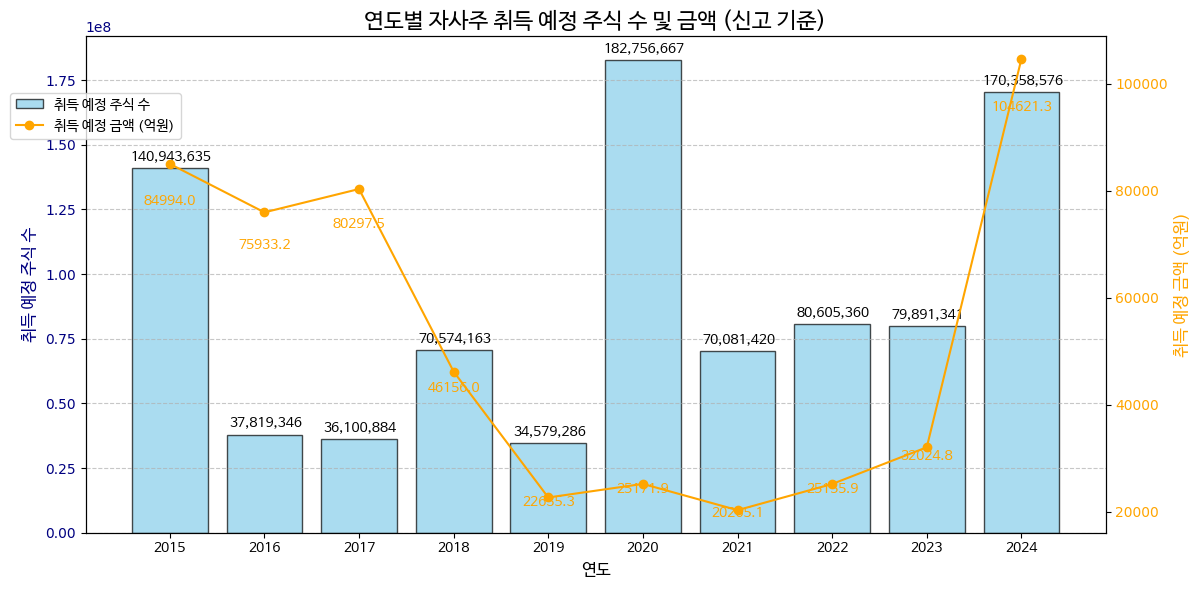

In [12]:
# 연도별 취득예정주식(주) 및 취득예정금액 집계
annual_summary = df_dart_buyback.groupby('연도').agg({
    '취득예정주식(주)_취득예정주식(주)_보통주식': 'sum',
    '취득예정금액(원)_취득예정금액(원)_보통주식': 'sum'
})

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 연도별 취득 예정 주식 수
bars = ax1.bar(annual_summary.index,
               annual_summary['취득예정주식(주)_취득예정주식(주)_보통주식'],
               color='skyblue', edgecolor='black', alpha=0.7, label='취득 예정 주식 수')
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('취득 예정 주식 수', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 (모든 연도 표시)
plt.xticks(annual_summary.index, fontproperties=font, fontsize=10)

# 데이터 라벨 추가 (막대 그래프)
texts = []
for bar in bars:
    height = bar.get_height()
    if height > 0:  # 데이터가 있는 경우에만 레이블 추가
        texts.append(ax1.text(bar.get_x() + bar.get_width() / 2., height,
                              f'{height:,.0f}', ha='center', va='bottom',
                              fontproperties=font, fontsize=10))

# 보조축 추가: 취득 예정 금액
ax2 = ax1.twinx()
line, = ax2.plot(annual_summary.index,
                 annual_summary['취득예정금액(원)_취득예정금액(원)_보통주식'],
                 color='orange', marker='o', label='취득 예정 금액 (억원)')
ax2.set_ylabel('취득 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 선 그래프 레이블 추가
for i, value in enumerate(annual_summary['취득예정금액(원)_취득예정금액(원)_보통주식']):
    ax2.text(annual_summary.index[i], value*0.9, f'{value:.1f}',
             color='orange', fontsize=10, ha='center', va='bottom', fontproperties=font)

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='upper right', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 취득 예정 주식 수 및 금액 (신고 기준)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()


### 자사주 직접취득 : 장내취득 vs 장외취득 구분자 달기

In [13]:
# 정규식 패턴 정의
pattern_mkt = re.compile(r'시장|장내|시간\s?외|거래소')  # '시간 외'와 '시간외'를 모두 포함
pattern_otc_exclude = re.compile(r'시장\s?외')  # '시장 외'와 '시장외'를 모두 포함

# method 열 생성
def categorize_method(method):
    if pattern_mkt.search(method) and not pattern_otc_exclude.search(method):
        return 'mkt'
    else:
        return 'otc'

# 새로운 열에 카테고리 할당
df_dart_buyback['method'] = df_dart_buyback['취득방법_취득방법_취득방법'].apply(categorize_method)

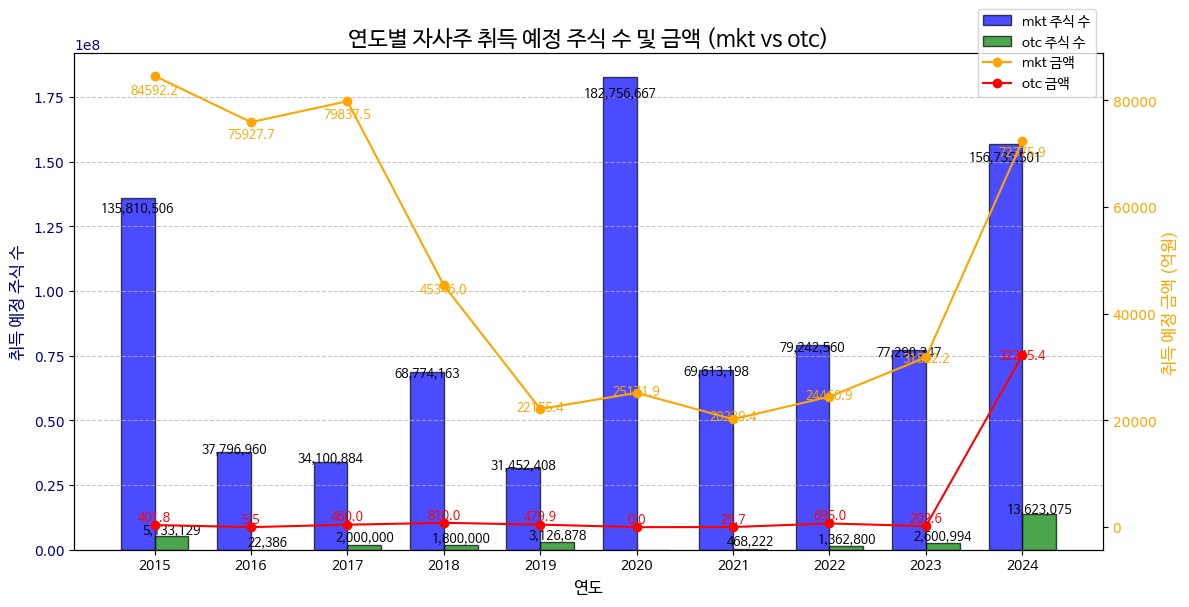

In [14]:
# 연도별 mkt, otc로 나눈 집계
annual_summary = df_dart_buyback.groupby(['연도', 'method']).agg({
    '취득예정주식(주)_취득예정주식(주)_보통주식': 'sum',
    '취득예정금액(원)_취득예정금액(원)_보통주식': 'sum'
}).reset_index()

# 연도별로 mkt와 otc로 나눠서 데이터 생성
mkt_summary = annual_summary[annual_summary['method'] == 'mkt']
otc_summary = annual_summary[annual_summary['method'] == 'otc']

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: mkt와 otc 별로 색상 다르게 표시
bar_width = 0.35  # 막대 폭
indices = mkt_summary['연도']  # x축 연도 값
bars_mkt = ax1.bar(indices - bar_width / 2,
                   mkt_summary['취득예정주식(주)_취득예정주식(주)_보통주식'],
                   color='blue', edgecolor='black', alpha=0.7, label='mkt 주식 수', width=bar_width)

bars_otc = ax1.bar(indices + bar_width / 2,
                   otc_summary['취득예정주식(주)_취득예정주식(주)_보통주식'],
                   color='green', edgecolor='black', alpha=0.7, label='otc 주식 수', width=bar_width)

# 축 라벨 및 눈금 설정
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('취득 예정 주식 수', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')
plt.xticks(indices, fontproperties=font, fontsize=10)

# 보조축 추가: mkt와 otc의 라인 그래프
ax2 = ax1.twinx()

line_mkt, = ax2.plot(mkt_summary['연도'],
                     mkt_summary['취득예정금액(원)_취득예정금액(원)_보통주식'] ,
                     color='orange', marker='o', label='mkt 금액')

line_otc, = ax2.plot(otc_summary['연도'],
                     otc_summary['취득예정금액(원)_취득예정금액(원)_보통주식'] ,
                     color='red', marker='o', label='otc 금액')

ax2.set_ylabel('취득 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 데이터 라벨 추가 (막대 및 라인 그래프)
for bar in bars_mkt:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, height * 0.95,
                 f'{height:,.0f}', ha='center', va='bottom',
                 fontproperties=font, fontsize=9)

for bar in bars_otc:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, height * 0.95,
                 f'{height:,.0f}', ha='center', va='bottom',
                 fontproperties=font, fontsize=9)

for i, value in enumerate(mkt_summary['취득예정금액(원)_취득예정금액(원)_보통주식'] ):
    ax2.text(mkt_summary['연도'].iloc[i], value * 0.95,
             f'{value:.1f}', color='orange', fontsize=9,
             ha='center', va='bottom', fontproperties=font)

for i, value in enumerate(otc_summary['취득예정금액(원)_취득예정금액(원)_보통주식'] ):
    ax2.text(otc_summary['연도'].iloc[i], value * 0.95,
             f'{value:.1f}', color='red', fontsize=9,
             ha='center', va='bottom', fontproperties=font)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 취득 예정 주식 수 및 금액 (mkt vs otc)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

전반적으로 장외취득은 미미한 수준이나, 2024년에 유의미하게 높음
2024년 데이터를 확인해보니, 고려아연에서 발생한 경영권분쟁 관련 공개매수에 의한 것이었음

In [21]:
# 2024년 내역 확인
df_show = df_dart_buyback[df_dart_buyback['연도']==2024].sort_values(by='취득예정금액(원)_취득예정금액(원)_보통주식', ascending=False)
df_show[['회사명_회사명_회사명', '접수일_접수일_접수일', '취득예정주식(주)_취득예정주식(주)_보통주식', '취득예정금액(원)_취득예정금액(원)_보통주식', '연도', 'method']]

,회사명_회사명_회사명,접수일_접수일_접수일,취득예정주식(주)_취득예정주식(주)_보통주식,취득예정금액(원)_취득예정금액(원)_보통주식,연도,method
16,유고려아연,2024-10-11,3623075.0,32245.367500,2024,otc
60,유삼성전자,2024-11-18,50144628.0,26827.375980,2024,mkt
38,유현대자동차,2024-11-27,3906545.0,8731.128075,2024,mkt
37,유기아,2024-01-25,5688282.0,5000.000000,2024,mkt
74,유NAVER IR,2024-09-30,2347500.0,4011.877500,2024,mkt
...,...,...,...,...,...,...
92,유SK아이이테크놀로지,2024-02-02,1718.0,1.285064,2024,mkt
19,유이마트 IR,2024-07-18,1000.0,0.576000,2024,mkt
31,유금양,2024-10-31,10000000.0,0.000000,2024,otc
94,유한화 IR,2024-07-05,0.0,0.000000,2024,otc


## (참고) 금감원 공시를 통해 자사주 직접 *****처분*****  통계 불러오기
*주요사항보고서(자사주처분) 공시기준 데이터이기 때문에, 실제 취득수량과는 차이가 있음

1) 검색 기준이 되는 인풋 입력하기

In [40]:
# 사용자 입력 받기
start_y = input('시작연도를 입력하세요(2015년부터 데이터 제공): ')
end_y = input('종료연도를 입력하세요: ')
corp_type_input = input('유, 코, 유코 중에서 하나를 입력하세요 :')

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": "11333" #직접취득 11332, 직접처분 11333, 신탁취득 11334, 신탁해지 11335
}

# corpType 설정
corp_type_map = {
    "유": "P",
    "코": "A",
    "유코": ["P", "A"]
}

if corp_type_input in corp_type_map:
    params["corpType"] = corp_type_map[corp_type_input]
else:
    print('잘못된 입력입니다. 재실행하세요')

# 결과 출력
params

시작연도를 입력하세요(2015년부터 데이터 제공): 2015
종료연도를 입력하세요: 2024
유, 코, 유코 중에서 하나를 입력하세요 :유


{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2015-01-01',
 'endDe': '2024-12-31',
 'textCrpNm': '',
 'startDate': '2015-01-01',
 'endDate': '2024-12-31',
 'reportCode': '11333',
 'corpType': 'P'}

2) 처음 크롤링은 페이지 인덱스 1을 기준으로 하고, 크롤링 결과물에서 페이지가 2이상일 경우 추가로 크롤링을 수행
  * 첫번째 페이지 인덱스의 내용을 데이터프레임으로 만들기

In [41]:
# 첫번째 페이지 크롤링
url = 'https://opendart.fss.or.kr/disclosureinfo/mainMatter/list.do'
req = requests.post(url, params = params)

# 데이터를 수집할 빈 데이터프레임 생성
df_dart_buyback_sell = pd.DataFrame()

# 데이터프레임 파싱
content = req.content.decode('utf-8')
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

#데이터프레임 합치기
df_dart_buyback_sell = pd.concat([df_dart_buyback_sell, df_loop])

  * 페이지가 2이상일 경우 추가로 Loop을 통해 크롤링 수행
    - 페이지가 2이상일 경우 페이지 개수 확인하기

In [42]:
# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
# 백만단위 건수는 아닐거라는 가정임. 즉, 콤마가 많아도 하나만 있다는 가정임
match = re.match(r"\[(\d+)/(\d+)\] \[총 (\d+)?,?(\d+)건\]", output_string)

if match:
    total_page = int(match.group(2))
    if match.group(4):
      total_counts = int(match.group(3)+match.group(4))
    else :
      total_counts = int(match.group(3))
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts}")
else:
    print("출력물 형식이 올바르지 않습니다.")

total_page: 11
total_counts: 1007


*   확인한 페이지 개수대로 loop 돌리기



In [43]:
for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  sleep(1)

  #데이터프레임 합치기
  df_dart_buyback_sell = pd.concat([df_dart_buyback_sell, df_loop])

3) 다운받은 데이터프레임의 칼럼을 1단계로 축소하고 단위 변환하기

In [44]:
# 멀티인덱스를 1단계로 변환 (문자열 변환 추가)
df_dart_buyback_sell.columns = ['_'.join(map(str, filter(None, col))) for col in df_dart_buyback_sell.columns]

# 접수일을 datetime으로 변환 및 연도 추출
df_dart_buyback_sell['접수일_접수일_접수일'] = pd.to_datetime(df_dart_buyback_sell['접수일_접수일_접수일'])
df_dart_buyback_sell['연도'] = df_dart_buyback_sell['접수일_접수일_접수일'].dt.year

# 데이터 타입 변경
df_dart_buyback_sell['연도'] = pd.to_numeric(df_dart_buyback_sell['연도'], errors='coerce').astype('Int64')

df_dart_buyback_sell['처분예정주식(주)_처분예정주식(주)_보통주식'] = pd.to_numeric(
    df_dart_buyback_sell['처분예정주식(주)_처분예정주식(주)_보통주식'], errors='coerce').fillna(0)

df_dart_buyback_sell['처분예정금액(원)_처분예정금액(원)_보통주식'] = pd.to_numeric(
    df_dart_buyback_sell['처분예정금액(원)_처분예정금액(원)_보통주식'], errors='coerce').fillna(0) / 1e8  # 원 -> 억 원 변환

df_dart_buyback_sell.head()[['회사명_회사명_회사명', '접수일_접수일_접수일','처분예정주식(주)_처분예정주식(주)_보통주식', '처분예정금액(원)_처분예정금액(원)_보통주식', '연도']]

,회사명_회사명_회사명,접수일_접수일_접수일,처분예정주식(주)_처분예정주식(주)_보통주식,처분예정금액(원)_처분예정금액(원)_보통주식,연도
0,유AJ네트웍스,2023-06-20,484943.0,22.889310,2023
1,유AK홀딩스,2018-04-12,150000.0,56.236500,2018
2,유BNK금융지주,2020-02-06,14855.0,1.030937,2020
3,유CJ,2019-12-09,1140809.0,1385.512530,2019
4,유CJ대한통운,2015-10-02,202338.0,397.620474,2015


### 시각화

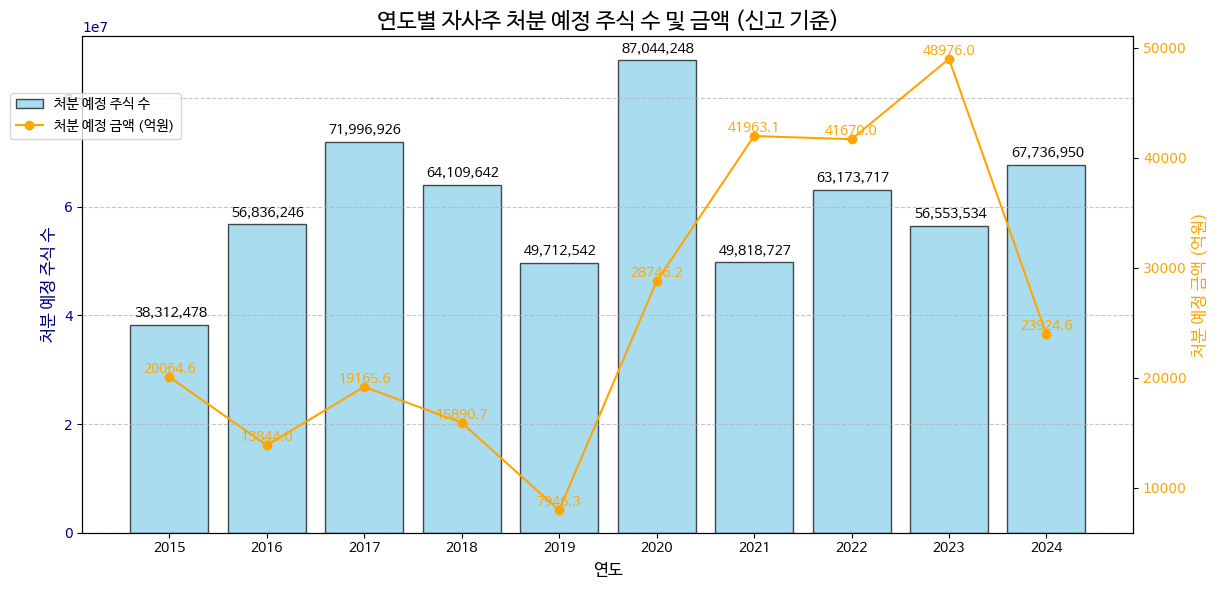

In [28]:
# 연도별 처분예정주식(주) 및 처분예정금액 집계
annual_summary = df_dart_buyback_sell.groupby('연도').agg({
    '처분예정주식(주)_처분예정주식(주)_보통주식': 'sum',
    '처분예정금액(원)_처분예정금액(원)_보통주식': 'sum'
})

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 연도별 취득 예정 주식 수
bars = ax1.bar(annual_summary.index,
               annual_summary['처분예정주식(주)_처분예정주식(주)_보통주식'],
               color='skyblue', edgecolor='black', alpha=0.7, label='처분 예정 주식 수')
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('처분 예정 주식 수', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 (모든 연도 표시)
plt.xticks(annual_summary.index, fontproperties=font, fontsize=10)

# 데이터 라벨 추가 (막대 그래프)
texts = []
for bar in bars:
    height = bar.get_height()
    if height > 0:  # 데이터가 있는 경우에만 레이블 추가
        texts.append(ax1.text(bar.get_x() + bar.get_width() / 2., height,
                              f'{height:,.0f}', ha='center', va='bottom',
                              fontproperties=font, fontsize=10))

# 보조축 추가: 취득 예정 금액
ax2 = ax1.twinx()
line, = ax2.plot(annual_summary.index,
                 annual_summary['처분예정금액(원)_처분예정금액(원)_보통주식'],
                 color='orange', marker='o', label='처분 예정 금액 (억원)')
ax2.set_ylabel('처분 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 선 그래프 레이블 추가
for i, value in enumerate(annual_summary['처분예정금액(원)_처분예정금액(원)_보통주식']):
    ax2.text(annual_summary.index[i], value, f'{value:.1f}',
             color='orange', fontsize=10, ha='center', va='bottom', fontproperties=font)

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='upper right', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 처분 예정 주식 수 및 금액 (신고 기준)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()


## 2. 거래소 기준의 자사주 취득/처분 통계 불러오기
(장내 수량만 카운트 됨. 장외 자사주 취득은 카운트 안됨)

* 정보데이터시스템(data.krx.co.kr)에서 자동으로 자료 다운받기

In [29]:
st_y = input('시작연도를 입력하세요(2012년부터 데이터 제공): ')
end_y = input('종료연도를 입력하세요: ')

시작연도를 입력하세요(2012년부터 데이터 제공): 2015
종료연도를 입력하세요: 2024


In [30]:
#거래소 홈페이지에서 불러오기
#화면번호 20004(자사주취득/처분종목현황)

gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp_data = {
    'locale': 'ko_KR',
    'mktId': 'ALL',
    'tboxisuCd_finder_stkisu0_2': '전체',
    'isuCd': 'ALL',
    'isuCd2': 'ALL',
    'param1isuCd_finder_stkisu0_2': 'ALL',
    'trstkTpCd': 'ALL',
    'trstkAcqstdispTpCd': 'ALL',
    'strtDd': f'{st_y}0101',
    'endDd': f'{end_y}1224',
    'share': '1',
    'money': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/issue/MDCSTAT20601'
}

headers = {
    'Referer': 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC03010201',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

otp = requests.post(gen_otp_url, gen_otp_data, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)


df_buyback = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')

In [31]:
# 확인해보기
print("행의 개수: " + str(len(df_buyback)))
df_buyback.tail()

행의 개수: 4723


,공시일,종목코드,종목명,시장구분,직접/신탁,취득/처분,취득(처분)예정기간_시작일,취득(처분)예정기간_종료일,신고내역_수량,신고내역_금액,체결내역(누계)_수량,체결내역(누계)_체결수량비율,체결내역(누계)_금액
4718,2015/01/06,000150,두산,KOSPI,신탁,취득,2015/01/06,2016/01/05,0,10000000000,87558.0,0.00,9.966629e+09
4719,2015/01/06,000150,두산,KOSPI,신탁,취득,2015/01/06,2016/01/05,0,10000000000,94757.0,0.00,9.976392e+09
4720,2015/01/06,024880,케이피에프,KOSDAQ,직접,취득,2015/01/07,2015/01/30,49204,173936140,49204.0,100.00,1.882532e+08
4721,2015/01/05,090740,연이비앤티,KOSDAQ,직접,취득,2015/01/06,2015/04/05,1000000,2300000000,1000000.0,100.00,2.682323e+09
4722,2015/01/02,044450,KSS해운,KOSPI,직접,취득,2015/01/05,2015/04/04,160000,2008000000,99121.0,61.95,1.236307e+09


* 연도별 유형별 취득수량/처분수량 구하기

In [32]:
# df_listed DataFrame 사용하여 연도별 유형별 취득수량/처분수량
# '공시일' 칼럼을 날짜형태로 변환
df_buyback['공시일'] = pd.to_datetime(df_buyback['공시일'])

# '공시일' 칼럼에서 연도를 뽑아내기
df_buyback['year'] = df_buyback['공시일'].dt.year

# 기준을 정하여 그룹화
grouped = df_buyback.groupby(['시장구분','year', '직접/신탁', '취득/처분']).agg({
    '신고내역_수량' : 'sum',
    '신고내역_금액' : 'sum',
    '체결내역(누계)_수량' : 'sum',
    '체결내역(누계)_금액' : 'sum'
}).reset_index()

# 원 -> 억 원 변환
grouped['신고내역_금액'] = grouped['신고내역_금액'] / 1e8
grouped['체결내역(누계)_금액'] = grouped['체결내역(누계)_금액'] / 1e8

# 시장구분: 유가
# 취득
# 직접
con1 = grouped['시장구분'] == 'KOSPI'
con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 & con2 & con3]

In [33]:
#확인해보기
grouped_con

,시장구분,year,직접/신탁,취득/처분,신고내역_수량,신고내역_금액,체결내역(누계)_수량,체결내역(누계)_금액
64,KOSPI,2015,직접,취득,137975612,97324.200013,137410358.0,97282.785180
67,KOSPI,2016,직접,취득,43658944,87816.815308,39048576.0,91598.485443
71,KOSPI,2017,직접,취득,36564065,94788.691713,35798399.0,97787.197844
75,KOSPI,2018,직접,취득,71057392,46784.117565,69153688.0,46567.165835
79,KOSPI,2019,직접,취득,33896491,22946.828688,33255244.0,24935.938294
83,KOSPI,2020,직접,취득,196677711,27690.730841,187033380.0,27639.224016
86,KOSPI,2021,직접,취득,75018607,21386.814897,74750544.0,21067.731705
90,KOSPI,2022,직접,취득,79342560,24515.781669,70531297.0,25016.778395
94,KOSPI,2023,직접,취득,77204876,31722.222295,74650467.0,31970.256971
98,KOSPI,2024,직접,취득,160388173,75488.742240,127136410.0,57303.624241


# 자사주 취득 신고대비 실제 취득비중 확인하기(장내취득限)

### 거래소 데이터로 신고대비 실제취득 확인(시각화)

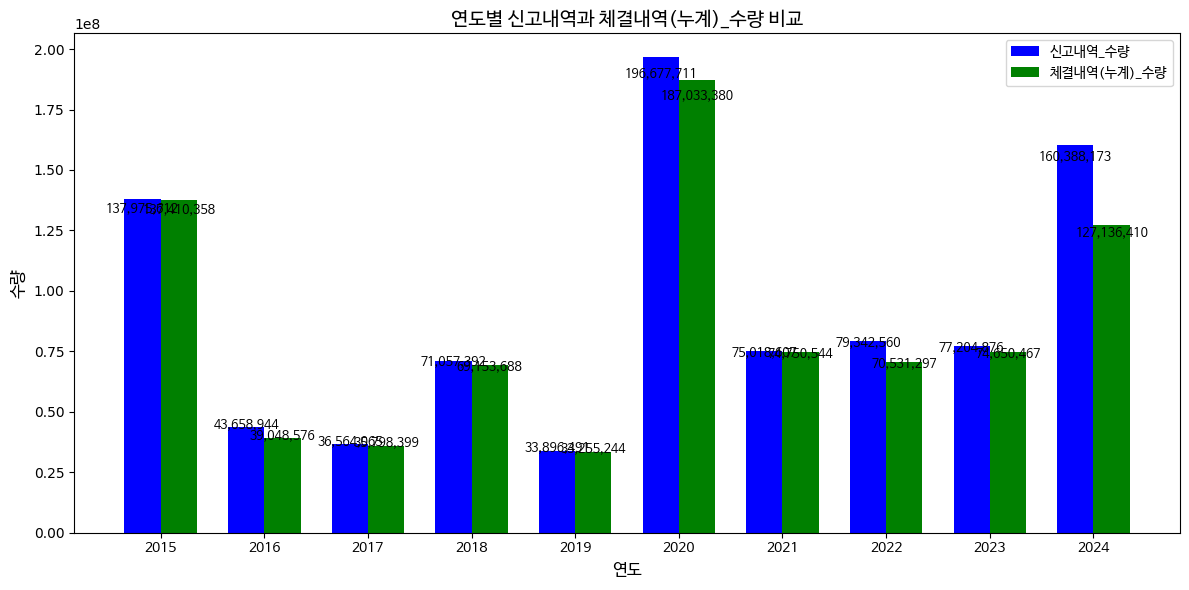

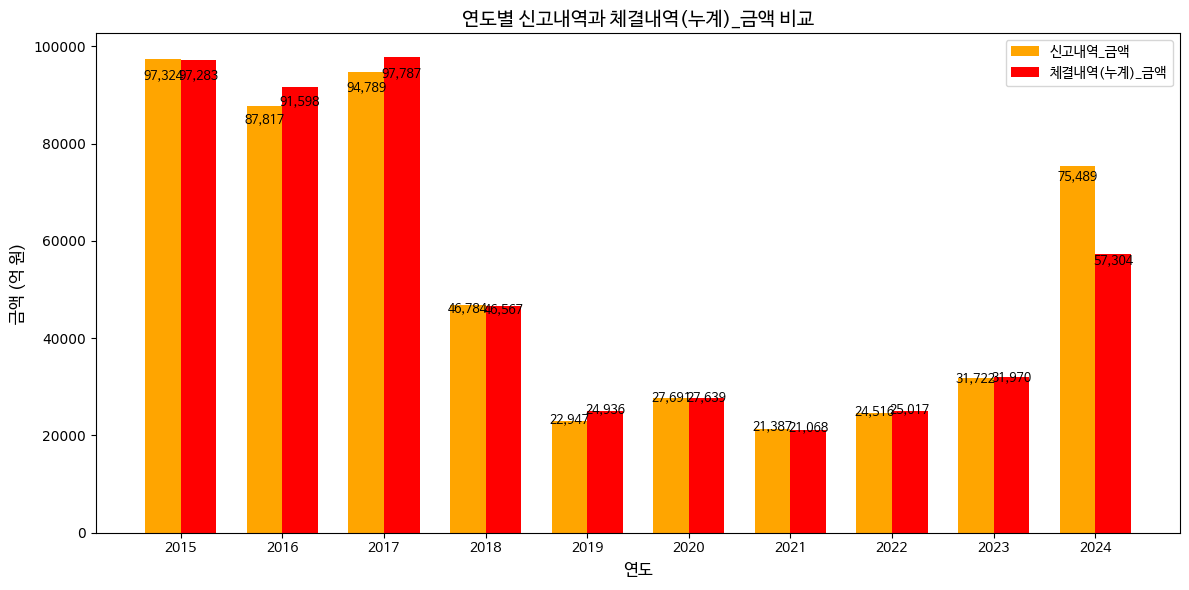

In [34]:
# 색상 및 막대 너비 설정
bar_width = 0.35
years = grouped_con['year']

# 1. 취득예정주식과 체결내역(누계)_수량 비교
fig, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(len(years))  # X축 위치
bars1 = ax1.bar(x - bar_width / 2, grouped_con['신고내역_수량'],
                width=bar_width, color='blue', label='신고내역_수량')
bars2 = ax1.bar(x + bar_width / 2, grouped_con['체결내역(누계)_수량'],
                width=bar_width, color='green', label='체결내역(누계)_수량')

ax1.set_xticks(x)
ax1.set_xticklabels(years, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('수량', fontproperties=font, fontsize=12)
ax1.legend(prop=font, fontsize=10)
plt.title('연도별 신고내역과 체결내역(누계)_수량 비교', fontproperties=font, fontsize=14)

# 데이터 라벨 추가
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

plt.tight_layout()
plt.show()

# 2. 취득예정금액과 체결내역(누계)_금액 비교
fig, ax2 = plt.subplots(figsize=(12, 6))

bars3 = ax2.bar(x - bar_width / 2, grouped_con['신고내역_금액'],
                width=bar_width, color='orange', label='신고내역_금액')
bars4 = ax2.bar(x + bar_width / 2, grouped_con['체결내역(누계)_금액'],
                width=bar_width, color='red', label='체결내역(누계)_금액')

ax2.set_xticks(x)
ax2.set_xticklabels(years, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('금액 (억 원)', fontproperties=font, fontsize=12)
ax2.legend(prop=font, fontsize=10)
plt.title('연도별 신고내역과 체결내역(누계)_금액 비교', fontproperties=font, fontsize=14)

# 데이터 라벨 추가
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

plt.tight_layout()
plt.show()


___
### (참고) 금감원 데이터와 거래소 데이터를 결합하여 신고대비 실제취득 확인
* 거래소의 신고데이터는 기본적으로 금감원 공시일자를 기반으로 작성됨
  - 따라서 장내 취득규모 확인은 거래소 데이터만 이용해도 됨
* 그러나 금감원의 장내취득 규모와 거래소 신고규모(장내)를 정합성 확인차원에서 비교하기로 함
  - 거래소의 자사주 신고 데이터의 '유가/취득/직접'은 grouped_con
  - 금감원 버전의 데이터프레임을 생성하기로 한다 : grouped_con_dart, grouped_con_dart_summary

In [35]:
# 금감원 데이터 만들기
# 조건 걸어서 필터
dart_con1 = df_dart_buyback['method']== 'mkt'
grouped_con_dart = df_dart_buyback[dart_con1]

# 칼럼명 변경
grouped_con_dart.rename(columns={'회사명_회사명_회사명':'회사명',
                                 '취득예정주식(주)_취득예정주식(주)_보통주식':'취득예정주식',
                                 '취득예정금액(원)_취득예정금액(원)_보통주식': '취득예정금액',
                                 '연도': 'year'}, inplace=True)
# 필요한 칼럼만 남기기
grouped_con_dart = grouped_con_dart[['회사명', 'year', '취득예정주식', '취득예정금액']]

# 연도별로 나눈 집계
grouped_con_dart_summary = grouped_con_dart.groupby('year').agg({
    '취득예정주식': 'sum',
    '취득예정금액': 'sum'
}).reset_index()
grouped_con_dart_summary

<ipython-input-35-0978a4b9ebbf>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,취득예정주식,취득예정금액
0,2015,135810506.0,84592.176014
1,2016,37796960.0,75927.676026
2,2017,34100884.0,79837.501730
3,2018,68774163.0,45346.005711
4,2019,31452408.0,22155.414025
5,2020,182756667.0,25171.863785
6,2021,69613198.0,20239.438419
7,2022,79242560.0,24460.881669
8,2023,77290347.0,31822.223365
9,2024,156735501.0,72375.896642


In [36]:
# 거래소 데이터 필요한 칼럼만 남기기
grouped_con = grouped_con[['year', '체결내역(누계)_수량', '체결내역(누계)_금액']]
grouped_con

,year,체결내역(누계)_수량,체결내역(누계)_금액
64,2015,137410358.0,97282.785180
67,2016,39048576.0,91598.485443
71,2017,35798399.0,97787.197844
75,2018,69153688.0,46567.165835
79,2019,33255244.0,24935.938294
83,2020,187033380.0,27639.224016
86,2021,74750544.0,21067.731705
90,2022,70531297.0,25016.778395
94,2023,74650467.0,31970.256971
98,2024,127136410.0,57303.624241



#### 시각화

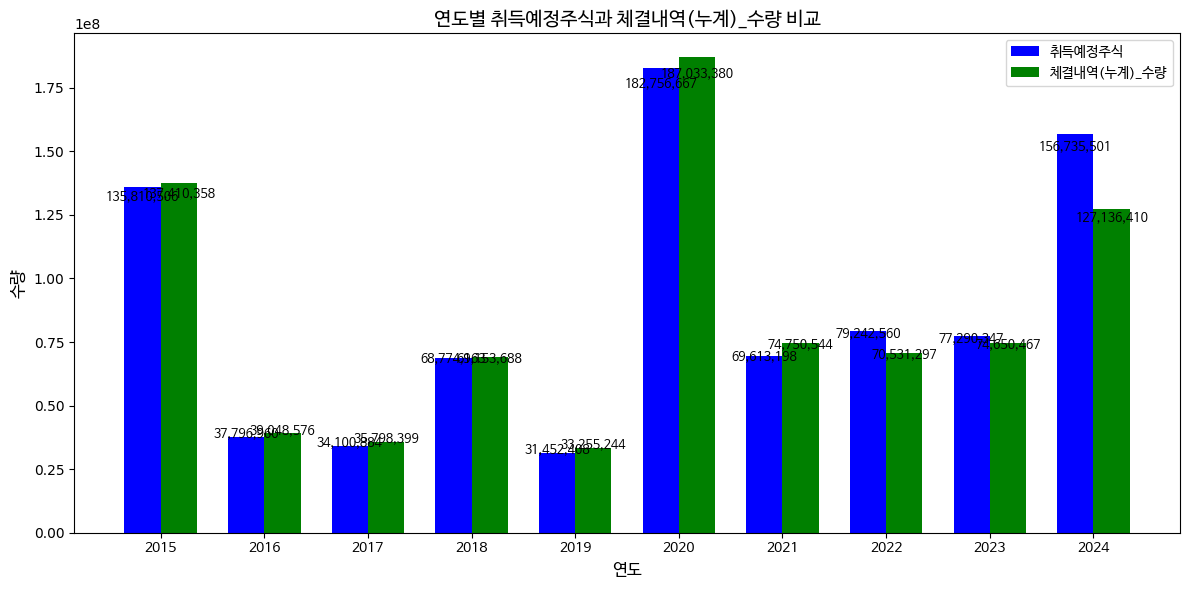

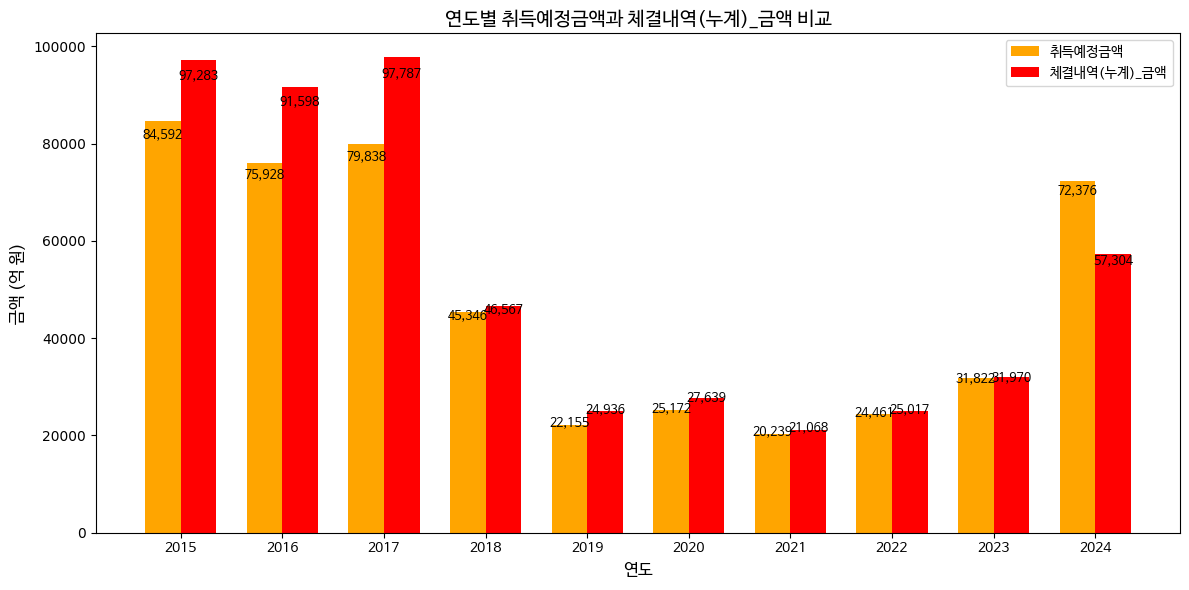

In [37]:
# 색상 및 막대 너비 설정
bar_width = 0.35
years = grouped_con_dart_summary['year']

# 1. 취득예정주식과 체결내역(누계)_수량 비교
fig, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(len(years))  # X축 위치
bars1 = ax1.bar(x - bar_width / 2, grouped_con_dart_summary['취득예정주식'],
                width=bar_width, color='blue', label='취득예정주식')
bars2 = ax1.bar(x + bar_width / 2, grouped_con['체결내역(누계)_수량'],
                width=bar_width, color='green', label='체결내역(누계)_수량')

ax1.set_xticks(x)
ax1.set_xticklabels(years, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('수량', fontproperties=font, fontsize=12)
ax1.legend(prop=font, fontsize=10)
plt.title('연도별 취득예정주식과 체결내역(누계)_수량 비교', fontproperties=font, fontsize=14)

# 데이터 라벨 추가
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

plt.tight_layout()
plt.show()

# 2. 취득예정금액과 체결내역(누계)_금액 비교
fig, ax2 = plt.subplots(figsize=(12, 6))

bars3 = ax2.bar(x - bar_width / 2, grouped_con_dart_summary['취득예정금액'],
                width=bar_width, color='orange', label='취득예정금액')
bars4 = ax2.bar(x + bar_width / 2, grouped_con['체결내역(누계)_금액'],
                width=bar_width, color='red', label='체결내역(누계)_금액')

ax2.set_xticks(x)
ax2.set_xticklabels(years, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('금액 (억 원)', fontproperties=font, fontsize=12)
ax2.legend(prop=font, fontsize=10)
plt.title('연도별 취득예정금액과 체결내역(누계)_금액 비교', fontproperties=font, fontsize=14)

# 데이터 라벨 추가
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height * 0.95,
             f'{height:,.0f}', ha='center', va='bottom', fontproperties=font, fontsize=9)

plt.tight_layout()
plt.show()


큰 차이는 아니긴 하지만 신고수량보다 실제 취득수량이 큰 경우가 종종 있음